# Importing modules


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Load the Dataset

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


In [ ]:
len(df)

159571

#Exploratory data Analysis

In [ ]:
x = df.iloc[:,2:].sum() # taking only label counts
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [ ]:
rowsums = df.iloc[:,2:].sum(axis=1) # Take label colums and sum at columnswise
rowsums

,0
0,0
1,0
2,0
3,0
4,0
...,...
159566,0
159567,0
159568,0
159569,0


In [ ]:

no_label_count = 0

for i, count in rowsums.items():
    if count == 0:
        no_label_count += 1

print('Total number of comments:', len(df))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())

Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


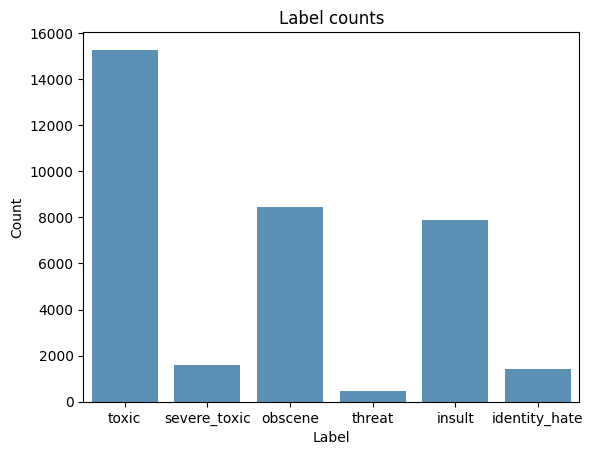

In [ ]:
plt.figure9figsize= (5, 3)
ax = sns.barplot(x =x.index, y=x.values, alpha=0.8)
plt.title('Label counts')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

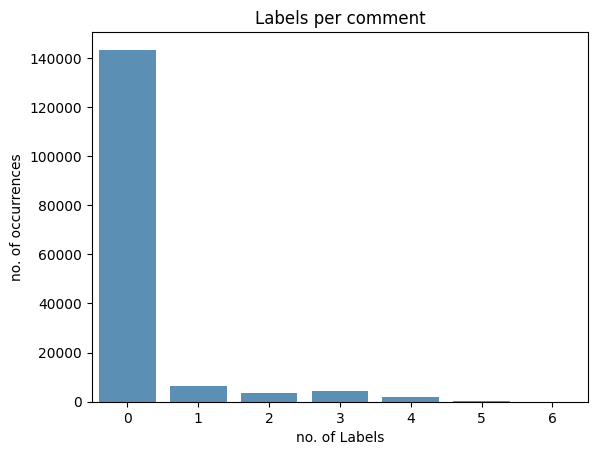

In [26]:
plt.figure9figsize= (5, 3)
ax = sns.countplot(x = rowsums.values, alpha=0.8)
plt.title('Labels per comment')
plt.ylabel('no. of occurrences')
plt.xlabel('no. of Labels')
plt.show()

# Data Preprocessing

In [ ]:
df= df.drop(['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [30]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Get stopwords from nltk.corpus
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return" ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#stemming

In [31]:
stemmer = SnowballStemmer("english")
def stemming(text):
    stemmed_sentence =""
    for word in text.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word +" "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [32]:
# preprocessing the comment
df['comment_text'] = df['comment_text'].apply(lambda x: remove_stopwords(x))
df['comment_text'] = df['comment_text'].apply(lambda x: clean_text(x))
df['comment_text'] = df['comment_text'].apply(lambda x: stemming(x))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explan whi edit made usernam hardcor metallica...,0,0,0,0,0,0
1,aww match background colour seem stuck thank t...,0,0,0,0,0,0
2,hey man realli tri edit war guy constant remov...,0,0,0,0,0,0
3,make real suggest improv wonder section statis...,0,0,0,0,0,0
4,sir hero ani chanc rememb page,0,0,0,0,0,0


In [33]:
#split input and output
X = df['comment_text']
y = df.drop(columns=['comment_text'], axis=1)

In [34]:
#split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

In [38]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])


In [37]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('RF_model', OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1))
])


In [ ]:
run_pipeline(RF_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9567265205395339
accuracy: 0.9168416105279649
classification report
               precision    recall  f1-score   support

        toxic       0.91      0.58      0.71      3056
 severe_toxic       0.58      0.09      0.16       321
      obscene       0.91      0.63      0.75      1715
       threat       0.50      0.07      0.12        74
       insult       0.82      0.46      0.59      1614
identity_hate       0.77      0.07      0.12       294

    micro avg       0.89      0.52      0.65      7074
    macro avg       0.75      0.32      0.41      7074
 weighted avg       0.87      0.52      0.64      7074
  samples avg       0.05      0.04      0.05      7074



In [ ]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.8615429810312983
accuracy: 0.8999216669277769
classification report
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.98      0.11      0.21      1715
       threat       1.00      0.01      0.03        74
       insult       0.96      0.05      0.10      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.12      0.22      7074
    macro avg       0.65      0.06      0.11      7074
 weighted avg       0.89      0.12      0.21      7074
  samples avg       0.02      0.01      0.01      7074



In [39]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9789310793145419
accuracy: 0.9182829390568699
classification report
               precision    recall  f1-score   support

        toxic       0.90      0.62      0.74      3056
 severe_toxic       0.58      0.28      0.37       321
      obscene       0.91      0.64      0.75      1715
       threat       0.69      0.15      0.24        74
       insult       0.81      0.52      0.63      1614
identity_hate       0.69      0.16      0.26       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.76      0.39      0.50      7074
 weighted avg       0.86      0.56      0.68      7074
  samples avg       0.06      0.05      0.05      7074



#Text Prediction

In [40]:
labels= y_train.columns.values
labels

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [41]:
X_test.sample(1).values[0]

'least usa'

In [63]:
sentence = 'asshole'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
   print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0


In [43]:
sentence = 'i am going to kill you'
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
   print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     0
        threat     1
        insult     0
 identity_hate     0


#ROC curve


In [61]:
sentence = '@sshole'
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
   print("%14s %5s" % (label, result))

         toxic     0
  severe_toxic     0
       obscene     0
        threat     0
        insult     0
 identity_hate     0


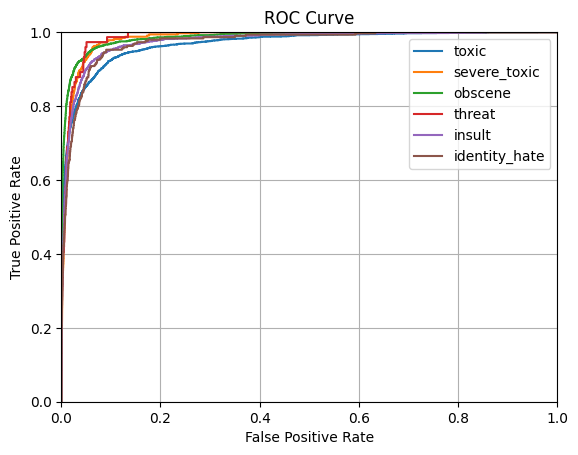

In [ ]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)

def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plot_pipeline_roc_curve(LR_pipeline, X_train, X_test, y_train, y_test)